In [1]:
#import requests
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
import geopandas
import geoplot
import geoplot.crs as gcrs

import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib as mpl
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage, TextArea)
import seaborn as sns

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader

import pyarrow as pa
import pyarrow.parquet as pq
import json

In [266]:
#yield_data.loc[yield_data['country'] == 'Uganda']

In [3]:
East_Africa = ['Kenya', 'Ethiopia', 'Uganda', 'Tanzania', 'Somalia', 'South Sudan']

In [4]:
adm_data_EA = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\hvstat_africa_boundary_v1.0.gpkg')
adm_data_EA = adm_data_EA.loc[adm_data_EA['ADMIN0'].isin(East_Africa)].rename(columns = {'ADMIN0': 'admin_0', 'ADMIN1': 'admin_1', 'ADMIN2': 'admin_2'})
adm_data = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\KE_boundaries\\adm_boundaries.geojson')
adm_data = adm_data.loc[adm_data['name'] != 'Kenya']
adm_data.drop(columns = ['end_date', 'country_code', 
                         'fewsnet_region', 'geographic_group', 
                         'es_name', 'fr_name', 'pt_name',
                         'ar_name', 'country',
                         'admin_3', 'admin_4', 'layer_id',
                         'geographicunitsetversion_name', 'zone_type', 'urban_rural', 'start_month',
                         ], inplace=True)

Skipping field centroid: unsupported OGR type: 3


In [ ]:
#### CHECK THAT WE ONLY HAVE ONE YEAR OF FEWSNET BOUNDARIES ####
#print(adm_data.loc[adm_data['ADMIN0'] == 'Ethiopia']['FNID'].str[2:6].unique(),
#      adm_data.loc[adm_data['ADMIN0'] == 'Uganda']['FNID'].str[2:6].unique(),
#      adm_data.loc[adm_data['ADMIN0'] == 'Tanzania']['FNID'].str[2:6].unique(),
#      adm_data.loc[adm_data['ADMIN0'] == 'Somalia']['FNID'].str[2:6].unique(),
#      adm_data.loc[adm_data['ADMIN0'] == 'South Sudan']['FNID'].str[2:6].unique())

['2014'] ['2007'] ['2012'] ['1990'] ['2011']


In [6]:
#yield_data_polygons['planting_year'].min()

In [128]:
with open('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\downloaded_data\\era_agronomy_bundle_2025-05-12\\era_master_codes-2025-05-12.json', 'r') as file:
    era_master_codes = json.load(file)
era_fields_comp = era_master_codes["era_fields_v1"]
era_fields_comp = pd.DataFrame(era_fields_comp)
#M.year !!!!
#MeanT !!!!
#MeanC !!!!
#Buffer !!!! (meters)
era_fields_comp[era_fields_comp['Description'].str.contains('location', case=False, na=False)]#.loc[71,'Description']#
era_fields_comp.loc[era_fields_comp['Field.Name'] == 'Buffer','Description'].values#]
era_fields_comp['Field.Name'].to_list()
ERA_compiled = pq.read_table('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\downloaded_data\\era_agronomy_bundle_2025-05-12\\era_compiled-v1.0-mh_2025-03-19.2-sc_2025_01_30.1-ie_2025_05_09.2-2025-05-09.1.parquet')
#ERA_compiled#['Product']#.to_pandas()
def compiled_cols_to_pandas(cols):
    yield_data = {col: ERA_compiled[col] for col in cols}
    return pd.DataFrame(yield_data)
ERA_compiled
yd = compiled_cols_to_pandas(['Code', 'Product', 'obs_count', 'Out.SubInd', 'M.Year', 'Latitude', 'Longitude', 'MeanC', 'MeanT', 'Buffer'])#, 'Plant.Start', 'Plant.End', 'Harvest.Start', 'Harvest.End',
yd = yd.dropna(subset=['M.Year'], how='all')
yd = yd.dropna(subset = ['Latitude', 'Longitude'], how='all')
yd = yd.loc[yd['M.Year'].str.len() <= 6]
yd.loc[:, 'M.Year'] = yd.loc[:, 'M.Year'].str.replace(r'\D', '', regex=True).str[:4]
yd = yd.loc[yd['M.Year'].str.len() >= 4]
yd.loc[:, 'M.Year'] = yd.loc[:, 'M.Year'].astype(int)
yd = yd.loc[(yd['M.Year'] < 2100) & (yd['M.Year'] >= 1975)]
yd = yd.loc[yd['Out.SubInd'] == 'Crop Yield']
yd = yd.loc[yd['Product'] == 'Maize']
#yd.loc[:, 'Plant.Start'] = pd.to_datetime(yd['Plant.Start'], format='%Y-%m-%d')
#yd['Plant.Start'].max()
geometry = geopandas.points_from_xy(yd['Longitude'], yd['Latitude'])
ygd = geopandas.GeoDataFrame(yd, geometry=geometry, crs='EPSG:4326')
era_Kenya = adm_data.overlay(ygd, how='intersection', keep_geom_type=False)
era_EA = adm_data_EA.overlay(ygd, how='intersection', keep_geom_type=False)
#era_EA = era_EA.rename(columns = {'ADMIN0': 'admin_0', 'ADMIN1': 'admin_1', 'ADMIN2': 'admin_2'})

In [168]:
era_sites = era_Kenya.drop_duplicates(subset = ['Out.SubInd', 'M.Year', 'Latitude', 'Longitude'])#, 'MeanC', 'MeanT', 'Buffer'

In [169]:
era_sites = era_sites[['admin_1', 'M.Year']]

In [161]:
era_sites = era_sites.merge(adm_data.loc[adm_data['unit_type'] == 'Admin 1'], how='left', on=['admin_1'])

In [170]:
era_sites = adm_data.loc[adm_data['unit_type'] == 'Admin 1'].merge(era_sites, how='right', on=['admin_1'])

In [187]:
#era_sites#['M.Year']

In [172]:
era_sites = era_sites[['admin_1', 'geometry', 'M.Year']].dissolve(by='admin_1', aggfunc='count')

In [182]:
era_sites.loc[:, 'centroid'] = era_sites.loc[:, 'geometry'].to_crs(crs=3857).centroid.to_crs('EPSG:4326')

In [183]:
era_sites = era_sites.set_geometry('centroid')

Text(0.5, 1.0, 'Number of ERA experiments by region in Kenya')

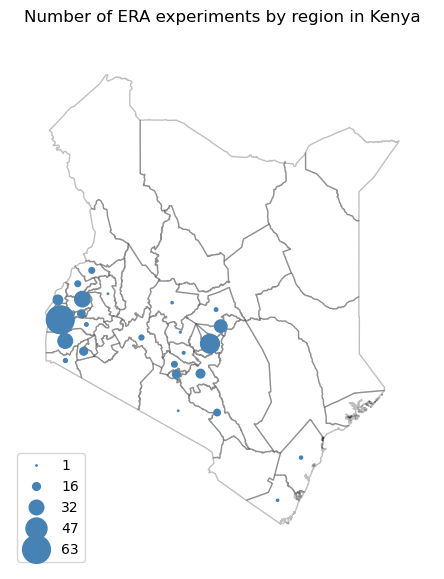

In [198]:
fig, ax = plt.subplots(figsize = (7, 7))
geoplot.pointplot(era_sites.explode(), scale='M.Year', limits=(1, 20), ax=ax, legend=True)#, legend_kwargs={'legend_labels': 'Number of ERA experiments'})
geoplot.polyplot(adm_data.loc[adm_data['unit_type'] == 'Admin 1'].explode(), ax=ax, alpha=0.25)
ax.set_title('Number of ERA experiments by region in Kenya')

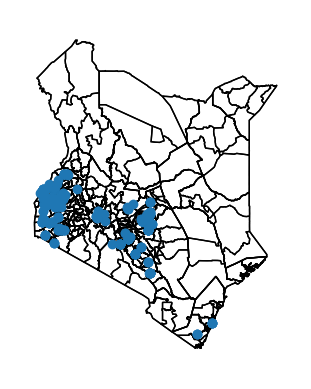

In [142]:
fig, ax= plt.subplots()
geoplot.polyplot(adm_data.explode(), ax=ax)
ax.scatter(era_sites['Longitude'], era_sites['Latitude'])

In [292]:
#era_EA.drop_duplicates(subset = ['Latitude', 'Longitude', 'M.Year'])

In [293]:
#era_Kenya.drop_duplicates(subset = ['Latitude', 'Longitude', 'M.Year'])

In [294]:
#era_EA.loc[era_Kenya['unit_type_code'] == 'admin2']['admin_1'].unique()

In [27]:
residue_obs = era_Kenya.loc[era_Kenya['Out.SubInd'] == 'Crop Residue Yield']
yield_obs = era_Kenya.loc[era_Kenya['Out.SubInd'] == 'Crop Yield']
biomass_obs = era_Kenya.loc[era_Kenya['Out.SubInd'] == 'Biomass Yield']
water_obs = era_Kenya.loc[era_Kenya['Out.SubInd'] == 'Water Use Efficiency']
SOC_obs = era_Kenya.loc[era_Kenya['Out.SubInd'] == 'Soil Organic Carbon']
SOC_obs = era_Kenya.loc[era_Kenya['Out.SubInd'] == 'Soil Moisture']

In [28]:
len(SOC_obs[['Latitude', 'Longitude', 'M.Year', 'MeanT']].groupby(['Latitude', 'Longitude', 'M.Year']).mean())

16

In [24]:
len(water_obs[['Latitude', 'Longitude', 'M.Year', 'MeanT']].groupby(['Latitude', 'Longitude', 'M.Year']).mean())

16

In [22]:
len(biomass_obs[['Latitude', 'Longitude', 'M.Year', 'MeanT']].groupby(['Latitude', 'Longitude', 'M.Year']).mean())

17

In [15]:
len(yield_obs[['Latitude', 'Longitude', 'M.Year', 'MeanT']].groupby(['Latitude', 'Longitude', 'M.Year']).mean())

376

In [16]:
len(residue_obs[residue_obs['Code'].isin(yield_obs['Code'])][['Latitude', 'Longitude', 'M.Year', 'MeanT']].groupby(['Latitude', 'Longitude', 'M.Year']).mean())

56

In [17]:
counts = era_Kenya['Out.SubInd'].value_counts()
enough_data = counts[counts > 200]
cats_to_keep = enough_data.index.to_numpy()

In [18]:
#### NOTE 1800 observations of harvest index (!?) 71 site-years :(
enough_data

Out.SubInd
Crop Yield                   7666
Crop Residue Yield           1434
Gross Margin                  864
Soil Moisture                 806
Pest & Pathogen (Losses)      684
Pest & Pathogen (Numbers)     670
Soil Organic Carbon           668
Soil Nitrogen                 504
Variable Cost                 492
Biomass Yield                 412
Water Use Efficiency          340
Gross Return                  332
Benefit Cost Ratio (GMVC)     258
Soil Total Nitrogen           250
Name: count, dtype: int64

In [205]:
len(cats_to_keep)

19

<Axes: xlabel='count', ylabel='Out.SubInd'>

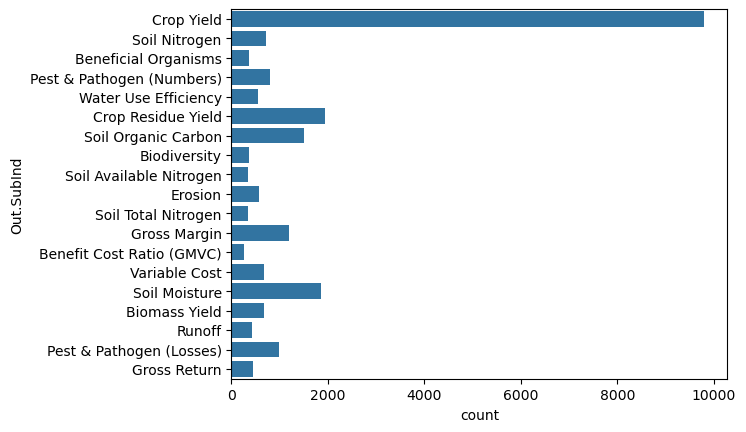

In [206]:
sns.countplot(era_Kenya['Out.SubInd'][era_Kenya['Out.SubInd'].isin(cats_to_keep)])

In [130]:
yield_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\hvstat_africa_data.csv')
yield_data = yield_data.loc[(yield_data['product'] == 'Maize')]
### NOTE USE HARVEST YEAR - WHEN PLANTING YEAR > HARVEST YEAR, THIS IS JUST FOR ANNUAL YIELDS
kenya_data = yield_data.loc[yield_data['country'] == 'Kenya']
EA_data = yield_data.loc[yield_data['country'].isin(East_Africa)]
kenya_data = kenya_data.loc[kenya_data['season_name'] == 'Annual']
EA_data = EA_data.loc[EA_data['season_name'] == 'Annual']
adm_data = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\KE_boundaries\\adm_boundaries.geojson')
adm_data = adm_data.loc[adm_data['name'] != 'Kenya']
adm_data.drop(columns = ['end_date', 'country_code', 
                         'fewsnet_region', 'geographic_group', 
                         'es_name', 'fr_name', 'pt_name',
                         'ar_name', 'country',
                         'admin_3', 'admin_4', 'layer_id',
                         'geographicunitsetversion_name', 'zone_type', 'urban_rural', 'start_month',
                         ], inplace=True)
adm_data.loc[:, 'centroid'] = adm_data.loc[:, 'geometry'].to_crs(crs=3857).centroid.to_crs('EPSG:4326')
adm_data_for_merging = adm_data.drop_duplicates(subset = ['admin_1']).drop(columns=['fnid', 'admin_2', 'start_date', 'id'])
yield_data_polygons = adm_data_for_merging.merge(kenya_data, on=['admin_1'], how='right')

Skipping field centroid: unsupported OGR type: 3


In [ ]:
adm_data

In [20]:
#len(ygd['M.Year'].unique())

In [19]:
#era_Kenya

In [131]:
plantorharvest = 'harvest'
era_dataset = era_Kenya
#era_Kenya = adm_data.overlay(ygd, how='intersection', keep_geom_type=False)
era_dataset = era_dataset.loc[(era_dataset['MeanC'] < 10) & (era_dataset['MeanT'] < 10)]
era_dataset = era_dataset.loc[(era_dataset['MeanC'] >= 0) & (era_dataset['MeanT'] >= 0)]
era_dataset.loc[:, 'full_mean'] = 0.5*(era_dataset.loc[:, 'MeanC'] + era_dataset.loc[:, 'MeanT'])
era_yields = era_dataset[['M.Year', 'Latitude', 'Longitude', 'admin_0', 'admin_1', 'admin_2', 'MeanC', 'MeanT', 'full_mean']].groupby(['M.Year', 'admin_0', 'admin_1', 'admin_2'], dropna=False).median()
era_yields = era_yields.reset_index().rename(columns = {'M.Year': f'{plantorharvest}_year'})#.merge(yield_data_)

In [49]:
#era_yields.loc[era_yields['admin_0'] == 'Kenya'].drop_duplicates(subset = ['harvest_year', 'admin_1', 'Latitude', 'Longitude'])#.loc[era_dataset['admin_0'] == 'Kenya'][['M.Year', 'admin_0', 'admin_1', 'admin_2', 'MeanC', 'MeanT', 'full_mean']].groupby(['M.Year', 'admin_0', 'admin_1', 'admin_2'], dropna=False).median()#['admin_0'].unique()

In [73]:
#era_yields

In [113]:
plantorharvest = 'harvest'
era_Kenya = adm_data.overlay(ygd, how='intersection', keep_geom_type=False)
era_Kenya = era_Kenya.loc[(era_Kenya['MeanC'] < 10) & (era_Kenya['MeanT'] < 10)]
era_Kenya['full_mean'] = 0.5*(era_Kenya['MeanC'] + era_Kenya['MeanT'])
era_yields = era_Kenya[['M.Year', 'admin_1', 'MeanC', 'MeanT', 'full_mean']]#.groupby(['M.Year', 'admin_1']).median()
era_yields = era_yields.rename(columns = {'M.Year': f'{plantorharvest}_year'})#.merge(yield_data_)

In [ ]:
era_Kenya.groupby(['admin_1']).mean()

,id,fnid,name,unit_type_code,parent_id,start_date,p_code,full_name,unit_type,admin_0,...,Product,obs_count,Out.SubInd,M.Year,Latitude,Longitude,MeanC,MeanT,Buffer,geometry
0,3094,KE2013A102,Kwale,admin1,3413.0,2013-01-01,KE002,"Kwale, Kenya",Admin 1,Kenya,...,Maize,144,Crop Yield,2015,-4.1943,39.2806,0.744186,1.767442,64000.0,POINT (39.2806 -4.1943)
1,3094,KE2013A102,Kwale,admin1,3413.0,2013-01-01,KE002,"Kwale, Kenya",Admin 1,Kenya,...,Maize,144,Crop Yield,2015,-4.1943,39.2806,0.744186,3.023256,64000.0,POINT (39.2806 -4.1943)
2,3094,KE2013A102,Kwale,admin1,3413.0,2013-01-01,KE002,"Kwale, Kenya",Admin 1,Kenya,...,Maize,144,Crop Yield,2015,-4.1943,39.2806,0.744186,4.232558,64000.0,POINT (39.2806 -4.1943)
3,3094,KE2013A102,Kwale,admin1,3413.0,2013-01-01,KE002,"Kwale, Kenya",Admin 1,Kenya,...,Maize,144,Crop Yield,2015,-4.1943,39.2806,0.744186,1.627907,64000.0,POINT (39.2806 -4.1943)
4,3094,KE2013A102,Kwale,admin1,3413.0,2013-01-01,KE002,"Kwale, Kenya",Admin 1,Kenya,...,Maize,144,Crop Yield,2015,-4.1943,39.2806,0.744186,2.558140,64000.0,POINT (39.2806 -4.1943)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,3323,KE2013A24717,Westlands,admin2,3105.0,2013-01-01,KE047274,"Westlands, Nairobi, Kenya",Admin 2,Kenya,...,Maize,30,Crop Yield,1989,-1.2500,36.7300,3.430000,4.430000,1000.0,POINT (36.73 -1.25)
7662,3323,KE2013A24717,Westlands,admin2,3105.0,2013-01-01,KE047274,"Westlands, Nairobi, Kenya",Admin 2,Kenya,...,Maize,30,Crop Yield,1990,-1.2500,36.7300,2.310000,4.290000,1000.0,POINT (36.73 -1.25)
7663,3323,KE2013A24717,Westlands,admin2,3105.0,2013-01-01,KE047274,"Westlands, Nairobi, Kenya",Admin 2,Kenya,...,Maize,30,Crop Yield,1990,-1.2500,36.7300,3.360000,4.290000,1000.0,POINT (36.73 -1.25)
7664,3323,KE2013A24717,Westlands,admin2,3105.0,2013-01-01,KE047274,"Westlands, Nairobi, Kenya",Admin 2,Kenya,...,Maize,30,Crop Yield,1991,-1.2500,36.7300,2.010000,3.290000,1000.0,POINT (36.73 -1.25)


In [146]:
#era_Kenya['MeanT'].min()

In [147]:
enough_data

admin_1        admin_2
Bungoma        NaN         6
Busia          NaN        11
Embu           NaN        13
Homa Bay       NaN        10
Kajiado        NaN         1
Kakamega       NaN         9
Kiambu         NaN         9
Kilifi         NaN         2
Kisii          NaN        10
Kisumu         NaN         5
Kwale          NaN         3
Laikipia       NaN         2
Machakos       NaN        17
Makueni        NaN         7
Meru           NaN         2
Migori         NaN         3
Murang'a       NaN         4
Nairobi        NaN         6
Nakuru         NaN         3
Nyeri          NaN         2
Siaya          NaN        13
Tharaka Nithi  NaN         9
Trans Nzoia    NaN         8
Uasin Gishu    NaN         1
Vihiga         NaN         7
Name: count, dtype: int64

In [206]:
method = 'spatial'
if method == 'spatial':
    group_col = f'{plantorharvest}_year'
    ignore_col = ['admin_0', 'admin_1', 'admin_2', 'Latitude', 'Longitude']
elif method == 'temporal':
    group_col = ['admin_1', 'admin_2'] #'admin_0, 'Latitude', 'Longitude'
    ignore_col = ['admin_0', f'{plantorharvest}_year']

In [207]:
kenya_data = kenya_data.rename(columns={'country': 'admin_0'})
kenya_data.loc[:, 'admin_2'] = kenya_data.loc[:, 'admin_2'].replace('none', np.nan)

In [208]:
to_correlate = era_yields.merge(kenya_data[[f'{plantorharvest}_year', 'admin_0', 'admin_1', 'admin_2', 'yield']], on=[f'{plantorharvest}_year', 'admin_0', 'admin_1', 'admin_2'], how='left').dropna(subset=['yield'])
enough_data = to_correlate.drop(ignore_col, axis=1).groupby(group_col, dropna=False).count()['MeanC'].rename('count')#.loc[(slice(None), 'full_mean'), :]
if method == 'temporal':
    corrs = to_correlate.drop(ignore_col, axis=1).groupby(group_col, dropna=False).corr().loc[(slice(None), slice(None), 'full_mean'), :].reset_index(level=2, drop=True).loc[enough_data >4, :]
elif method == 'spatial':
    to_correlate[f'{plantorharvest}_year'] = pd.to_datetime(to_correlate[f'{plantorharvest}_year'], format = '%Y')
    to_correlate = to_correlate.set_index(f'{plantorharvest}_year')
    corrs = to_correlate.drop(ignore_col, axis=1).groupby(pd.Grouper(freq='1YE')).corr().loc[(slice(None), 'full_mean'), :].reset_index(level=1, drop=True)#.loc[enough_data >10, :]
print(len(corrs))#, len(corrs_to_plot))

34


Text(0.5, 1.0, 'Correlations between\nERA and FEWSNET by year')

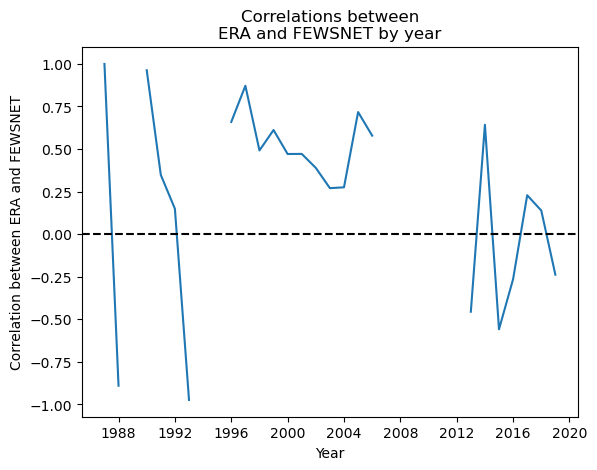

In [211]:
fig, ax = plt.subplots()
ax.plot(corrs.index, corrs['yield'])
ax.axhline(y=0, color='k', linestyle = '--')
ax.set_xlabel('Year')
ax.set_ylabel('Correlation between ERA and FEWSNET')
ax.set_title('Correlations between\nERA and FEWSNET by year')

In [135]:
corrs_to_plot = adm_data_for_merging.merge(corrs.reset_index(), on=['admin_1'])

In [136]:
corrs

,,Latitude,Longitude,MeanC,MeanT,full_mean,yield
admin_1,admin_2,,,,,,
Bungoma,NaN,0.135725,0.135976,0.537204,0.702290,1.0,-0.032329
Busia,NaN,0.202711,-0.127117,0.919458,0.933251,1.0,0.266624
Embu,NaN,0.489833,-0.355772,0.923994,0.982063,1.0,0.012702
Homa Bay,NaN,0.249697,0.731188,0.892315,0.990626,1.0,-0.101702
Kakamega,NaN,0.401568,-0.256810,0.938502,0.992032,1.0,-0.000955
Kiambu,NaN,-0.370645,0.370645,0.757110,0.914739,1.0,0.015284
Kisii,NaN,0.254254,0.156571,0.952632,0.985887,1.0,0.733304
Kisumu,NaN,0.948861,-0.333459,0.999670,0.997924,1.0,0.282097
Machakos,NaN,-0.274074,-0.265471,0.916464,0.931725,1.0,0.528798


Text(0.5, 1.0, 'Correlations between ERA and\nFEWSNET by region in Kenya')

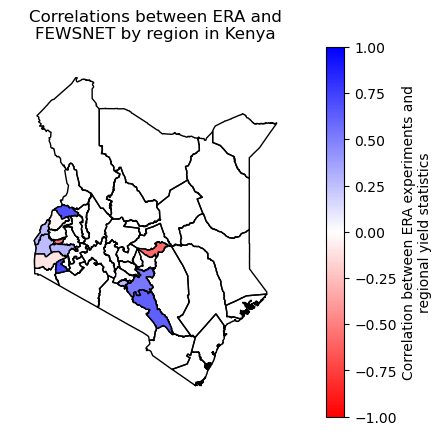

In [202]:
fig, ax = plt.subplots()
norm = mpl.colors.Normalize(vmin=-1,vmax=1)
geoplot.choropleth(corrs_to_plot.explode(), hue='yield', legend=True, ax=ax, cmap='bwr_r', norm=norm, legend_kwargs={'label': 'Correlation between ERA experiments and\nregional yield statistics'})
geoplot.polyplot(adm_data_for_merging.explode(), ax=ax)
ax.set_title('Correlations between ERA and\nFEWSNET by region in Kenya')

Text(0.5, 1.0, 'Correlation between ERA and FEWSNET datasets')

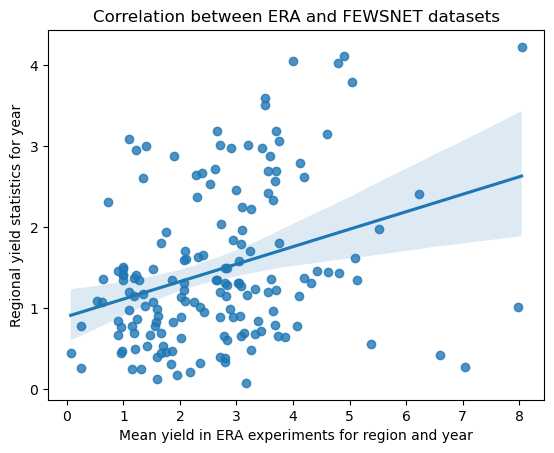

In [204]:
fig, ax = plt.subplots()
sns.regplot(data=to_correlate, x='full_mean', y='yield', ax=ax)
ax.set_xlabel('Mean yield in ERA experiments for region and year')
ax.set_ylabel('Regional yield statistics for year')
ax.set_title('Correlation between ERA and FEWSNET datasets')

In [139]:
to_correlate[['yield', 'full_mean']].corr()

,yield,full_mean
yield,1.000000,0.324965
full_mean,0.324965,1.000000


In [205]:
import scipy.stats
scipy.stats.pearsonr(to_correlate['full_mean'], to_correlate['yield'])

PearsonRResult(statistic=np.float64(0.32496482084220507), pvalue=np.float64(2.3121941331734523e-05))

In [ ]:

scipy.stats.ttest_ind(to_correlate['yield'], to_correlate['full_mean'])

TtestResult(statistic=np.float64(-9.351730745430409), pvalue=np.float64(1.6014970514595634e-19), df=np.float64(612.0))